# AVA Explorer

This notebook is dedicated to create a 3 layered model of AVA response. This notebook is highly inspired by aadm's notebook, you definitely should check aadm's Geophysical Notes amazing repo, and Matt Hall's tutorial on well tie calculus. Some of the functions and algorithms here were taken from those two notebooks and partially modified by my own needs.

* Geophysical_Notes by aadm : https://github.com/aadm/geophysical_notes
* Well-tie calculus by Matt Hall : https://github.com/seg/tutorials-2014/blob/master/1406_Make_a_synthetic/how_to_make_synthetic.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy

print(plt.style.available)
plt.style.use('seaborn-pastel')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


In [2]:
%matplotlib inline

## Synthetic Layer Parameters

* z10 = depth of top layer 1, z11 = depth of base layer 1
* z20 = depth of top layer 2, z21 = depth of base layer 2
* z30 = depth of top layer 3, z31 = depth of base layer 3

Top of layer 1 and base of layer 3 basically serves no purpose rather than being the plotting boundary, because the ava response will only happen at layer boundaries. But anyway i like to keep it.

assume above z10 = layer 1
assume above z31 = layer 3

We use this formula to calculate time for z domain
$$s = vt$$



In [174]:
'''z indicates boundary position in depth domain (m), 10 index means top layer 1, 11 means bottom layer 1 etc'''

#Depth==================#VP=========#VS============#Rho=================================                 
z10 = 1670 ; z11 = 1678 ; v1 = 2300 ; vs1 = 0.7*v1 ; rho1 = 2.66 #layer 1 parameters
z20 = z11  ; z21 = 1680 ; v2 = 2000 ; vs2 = 0.4*v2 ; rho2 = 2.5 #layer 2 parameters
z30 = z21  ; z31 = 1685 ; v3 = 2600 ; vs3 = 0.6*v3 ; rho3 = 2.66 # layer 3 parameters

In [175]:
#add margin before layer 1 and after layer 3
marg = 5 

#create depth array with sampling step dz
dz = 0.1
depth = np.arange(z10-marg,z31+(marg+dz),dz) 

#Fill vp, vs, rho array
v = np.array([v3 if x>z30 else v1 if x<=z11 else v2 for x in depth])
vs = np.array([vs3 if x>z30 else vs1 if x<=z11 else vs2 for x in depth])
rho = np.array([rho3 if x>z30 else rho1 if x<=z11 else rho2 for x in depth])

#convert depth to time using layer velocity
depth2 = np.arange(z10-(marg+dz),z31+(marg),dz)
dd = depth-depth2
time = 2*(np.cumsum((dd/v)*1000)+(depth[0]/v[0])*1000) #two-way travel time

#compute AI and reflectivity
ai = v*rho
rc = (ai[1:]-ai[:-1])/(ai[:-1]+ai[1:])
# plt.plot(rc,depth[:-1])

# Wavelet Creation

In [176]:
#Wavelet parameters (Ricker only)
dt = 0.001 #sampling step size (s)
freq = 15 #freq (Hz)
phase = 0 #Initial Phase

(0, 0.21419357801737543)

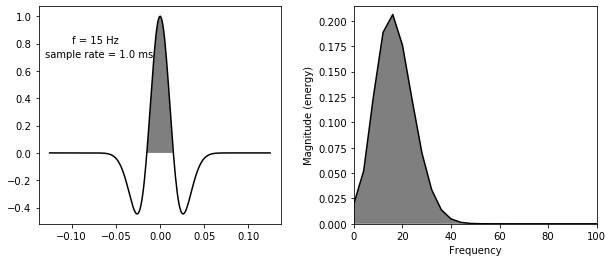

In [177]:
# Define a wavelet.
def ricker(f, length, dt, phase):
    t = np.linspace(-length/2, (length-dt)/2, int(length/dt))
    s = (1. - 2.*((np.pi)**2)*(f**2)*((t)**2))*np.exp(-((np.pi)**2)*(f**2)*((t)**2))
    
    phase = np.deg2rad(phase)
    s = hilbert(s)
    s = np.cos(phase)*np.real(s)-np.sin(phase)*np.imag(s)
    return t, s

#Create a wavelet
t2,y = ricker(f=freq, length=0.250, dt=dt, phase=phase)

#plot wavelet
f,ax=plt.subplots(1,2,figsize=(10,4))
f.subplots_adjust(wspace = 0.3)

ax[0].plot(t2,y,'k')
ax[0].fill_between(t2,0,y,where=y>0,facecolor='black',alpha=0.5)
ax[0].text(-0.1,0.8,f'f = {freq} Hz')
ax[0].text(-0.13,0.7,f'sample rate = {dt*1000} ms ')

mag,freq,line=ax[1].magnitude_spectrum(y,Fs=1/dt,c='k')
ax[1].set_xlim(0,100)
ax[1].fill_between(freq,0,mag,facecolor='k',alpha=0.5)
ax[1].set_ylim(0,max(mag)+np.mean(mag))


# Synthetic Seismogram

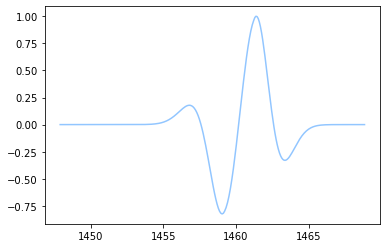

In [180]:
#Create synthetic
gain = 5
syn = np.convolve(rc,y,mode='same')
trace= syn / np.max(np.abs(syn))

plt.plot(time[:-1],trace)

# AVA Calculation

In [181]:


#Aki Richard 3 Terms
def aki_richard_3(teta,vp1,vp2,vs1,vs2,rho1,rho2):
    vp = (vp1+vp2)/2
    vs = (vs1+vs2)/2
    rho = (rho1+rho2)/2
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho = rho2-rho1
    vsvp2 = ((vs1/vp1)**2+(vs2/vp2)**2)/2

    A = 0.5*(dvp/vp + drho/rho)
    B = (dvp/(2*vp))-(4*(vsvp2)*(dvs/vs))-(2*vsvp2*(drho/rho))
    C = 0.5*(dvp/vp)

    t = np.deg2rad(teta)

    R = A+B*np.power(np.sin(t),2)+C*np.power(np.sin(t),2)*np.power(np.tan(t),2)
    Rn = (R - np.mean(R))/(np.max(R)-np.min(R))
    return R,Rn,A,B

#Aki Richard 2 Terms
def aki_richard_2(teta,vp1,vp2,vs1,vs2,rho1,rho2):
    vp = (vp1+vp2)/2
    vs = (vs1+vs2)/2
    rho = (rho1+rho2)/2
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho = rho2-rho1
    vsvp2 = ((vs1/vp1)**2+(vs2/vp2)**2)/2

    A = 0.5*(dvp/vp + drho/rho)
    B = (dvp/(2*vp))-(4*(vsvp2)*(dvs/vs))-(2*vsvp2*(drho/rho))
    t = np.deg2rad(teta)
    R = A+B*np.power(np.sin(t),2)
    Rn = (R - np.mean(R))/(np.max(R)-np.min(R))
    return R,Rn,A,B

def Hilterman(teta,vp1,vp2,vs1,vs2,rho1,rho2):
    ai1 = rho1*vp1
    ai2 = rho2*vp2
    pr1 = 0.5*(vp1**2-2*vs1**2)/(vp1**2-vs1**2)
    pr2 = 0.5*(vp2**2-2*vs2**2)/(vp2**2-vs2**2)
    
    t = np.deg2rad(teta)
    
    R = np.power(np.cos(t),2)*(ai2-ai1)/(ai2+ai1)+((pr2-pr1)/(1-((pr2+pr1)/2)))*np.power(np.sin(t),2)
    return R,A,B

In [182]:
#AVA Calculation
vu = v[:-1] #Upper layer Vp
vl = v[1:] #Lower layer Vp

vsu = vs[:-1] #Upper layer Vs
vsl = vs[1:] #Lower layer Vs

rhou = rho[:-1] #Upper layer Density
rhol = rho[1:] #Lower layer Density

#angle
ang = np.arange(0,70,5)
ravo,syn_ava = (np.zeros((vu.size,ang.size)) for _ in range(2))

#Create reflectivity matrix
for i in np.arange(len(ravo)):
    ravo[i,:],_,_,_ = aki_richard_3(ang,vu[i],vl[i],vsu[i],vsl[i],rhou[i],rhol[i])

#Create synthetic gather matrix
for i in np.arange(ravo.shape[1]):
    syn_ava[:,i] = np.convolve(y,ravo[:,i],mode='same')

#create trace
gain = 10
trace_ava = gain*syn_ava/np.max(np.abs(syn_ava)) #bug (why it has to be -?)

#Angle spacing
d=ang[1]-ang[0]

c:\users\pc-user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [183]:
yslice = 1678 #meter

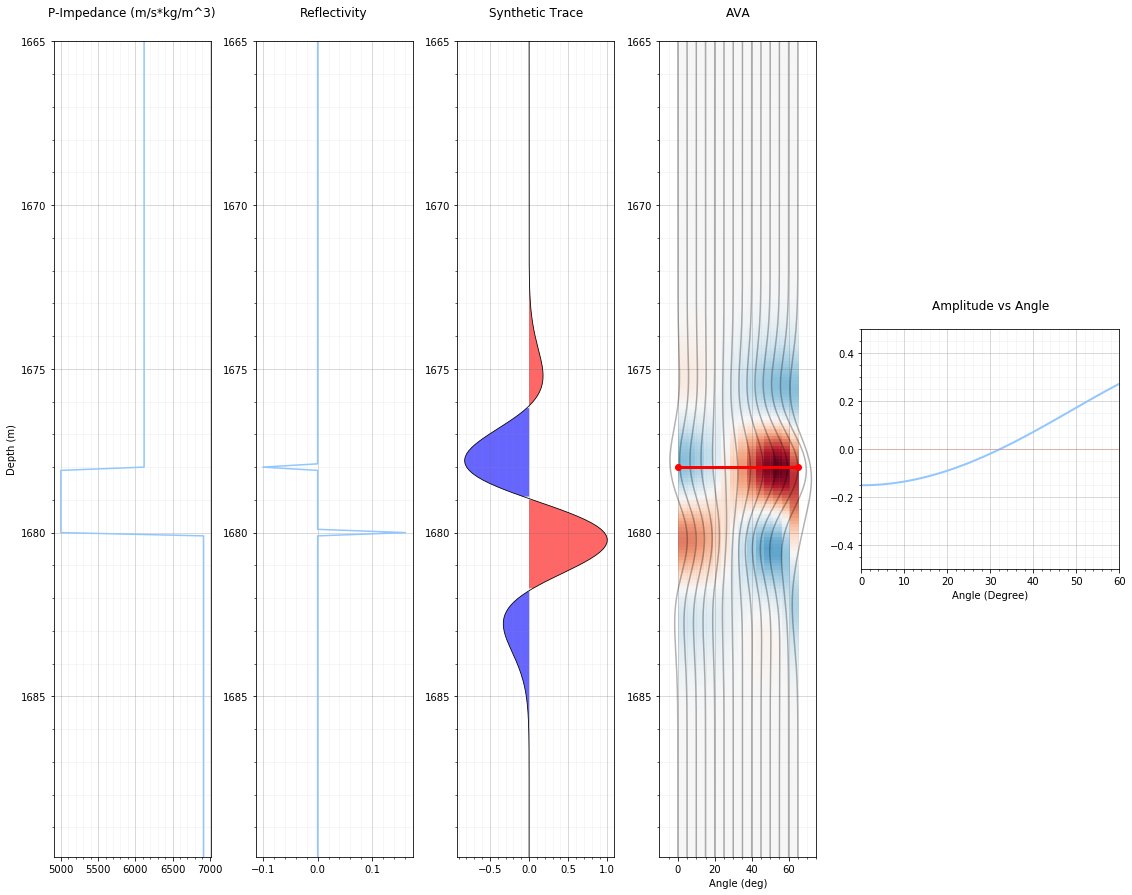

In [184]:
f, ax = plt.subplots(figsize=(18,15),sharey=True)
f.subplots_adjust(wspace = 0.8, left=0.05, right=0.95)

ax0 = plt.subplot2grid((3,12), (0,1), rowspan=3, colspan=2)
ax1 = plt.subplot2grid((3,12), (0,3), rowspan=3, colspan=2)
ax2 = plt.subplot2grid((3,12), (0,5), rowspan=3, colspan=2)
ax3 = plt.subplot2grid((3,12), (0,7), rowspan=3, colspan=2)
ax4 = plt.subplot2grid((3,12), (1,9), rowspan=1, colspan=3)

ax = [ax0,ax1,ax2,ax3]


# ax0.plot(v,depth,label='Vp (m/s)')
ax0.plot(ai,depth)
ax0.spines['top'].set_position(('outward',0))
ax0.tick_params(axis='x', colors='black')
ax0.set_title('P-Impedance (m/s*kg/m^3)',pad=25)    
# ax0.legend()
ax0.set_ylabel("Depth (m)")

ax1.plot(rc,depth[:-1])
ax1.spines['top'].set_position(('outward',0))
ax1.set_title('Reflectivity',pad=25)

ax2.plot(trace,depth[:-1],'k',linewidth=0.8)
ax2.fill_betweenx(depth[:-1],0,trace,where=trace>0,facecolor='r',alpha=0.6)
ax2.fill_betweenx(depth[:-1],0,trace,where=trace<0,facecolor='b',alpha=0.6)
# ax[2].axis('off')
ax2.set_title('Synthetic Trace',pad=25)

#======================================================================================================

def linint(inpx,inpy,x1,x2,X1,X2,y1,y2,Y1,Y2):
    'transpose plot coordinate to image coordinate'
    X = X1 + ((X2-X1)*((inpx-x1)/(x2-x1)))
    Y = Y1 + ((Y2-Y1)*((inpy-y1)/(y2-y1)))
    return X,Y

y = depth[:-1]

#minmax plot area
xmin = min(ang) ; xmax = max(ang)
ymin = min(y) ; ymax = max(y)

#minmax image index
Xmin = 0 ; Xmax = trace_ava.shape[1] 
Ymin = 0 ; Ymax = trace_ava.shape[0]

#Plotting coordinate 

xslice0 = min(ang)
xslice1 = max(ang)

#retrieve image coordinate
x0,y0 = np.round(linint(xmin,yslice,xmin,xmax,Xmin,Xmax,ymin,ymax,Ymin,Ymax))
x1,y1 = np.round(linint(xmax,yslice,xmin,xmax,Xmin,Xmax,ymin,ymax,Ymin,Ymax))

#extract value using PICTURE COORDINATES
num = 100
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
zi = scipy.ndimage.map_coordinates(np.transpose(syn_ava), np.vstack((x,y))) # THIS SEEMS TO WORK CORRECTLY

#======================================================================================================
clip=np.amax(abs(trace_ava))
ax3.imshow(trace_ava,origin='upper',extent=[0,65,max(depth[:-1]),min(depth)],cmap='RdBu_r',vmax=clip,vmin=-clip,aspect='auto')
# ax[3].pcolormesh(X,Y,trace_ava,cmap='RdBu_r')

for i in np.arange(ravo.shape[1]):
    ax3.plot(trace_ava[:,i]+i*d,depth[:-1],'k',alpha=0.3)
    ax3.autoscale(enable=True, axis='y', tight=True)
    ax3.autoscale(enable=True, axis='x', tight=True)
    ax3.set_title("AVA",pad=25)
    ax3.set_xlabel('Angle (deg)')

ax3.plot([xmin, xmax], [yslice, yslice], 'ro-',alpha=1,linewidth=3)
ax3.set_xlim(-10,75)
# ax[3].legend(loc='center')

ax4.plot(zi,label='Amplitude',linewidth=2)
ax4.axhline(y=0,xmin = 0,xmax=60,linewidth=0.6,color='r',alpha=0.3)
# ax4.plot(ravo[y0,:])
ax4.set_xlim([0,60])
ax4.set_ylim([-0.5,0.5])
ax4.minorticks_on()
ax4.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.3)
ax4.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax4.set_title('Amplitude vs Angle', pad =20)
ax4.set_xlabel('Angle (Degree)')


#General setting for all axis
for axes in ax:
    axes.minorticks_on()
    axes.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.3)
    axes.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    axes.set_ylim([min(depth),max(depth[:-1])])
    axes.invert_yaxis()
#     axes.plot([xmin, xmax], [yslice, yslice], 'r--',alpha=0.3,linewidth=3)




## Compute numerical derivatives of the trace

This is out of context, i just want to try something interesting.


In [185]:
#Numerical Derivative of the synthetic trace (FDM)

dx = depth[1]-depth[0]
trace_der = (trace[2:]-trace[:-2])/(2*dx)
depth_der = depth[1:-2]



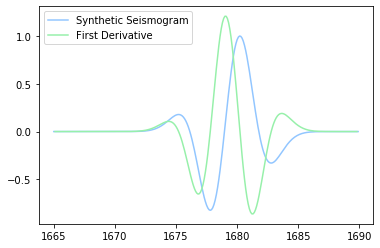

In [186]:
plt.plot(depth[:-1],trace,label='Synthetic Seismogram')
plt.plot(depth_der,trace_der,label='First Derivative')
plt.legend()

# To be investigated

I still have a doubt about the convolution process between wavelet and RC logs regarding to their sampling interval. 

(0, 0.23948648005239498)

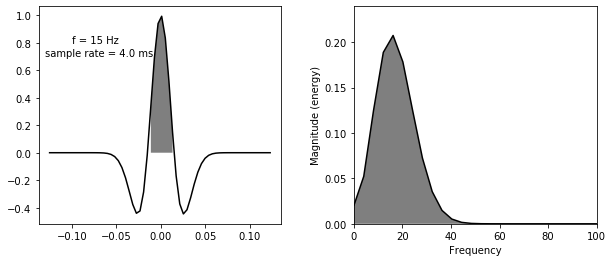

In [147]:
#resampled AI log to 4 ms and wavelet 4 ms


#Wavelet parameters (Ricker only)
dt = 0.004 #sampling step size (s)
freq = 15 #freq (Hz)
phase = 0 #Initial Phase

#Create a wavelet
t2,y2 = ricker(f=freq, length=0.250, dt=dt, phase=phase)

#plot wavelet
f,ax=plt.subplots(1,2,figsize=(10,4))
f.subplots_adjust(wspace = 0.3)

ax[0].plot(t2,y2,'k')
ax[0].fill_between(t2,0,y2,where=y2>0,facecolor='black',alpha=0.5)
ax[0].text(-0.1,0.8,f'f = {freq} Hz')
ax[0].text(-0.13,0.7,f'sample rate = {dt*1000} ms ')

mag,freq,line=ax[1].magnitude_spectrum(y2,Fs=1/dt,c='k')
ax[1].set_xlim(0,100)
ax[1].fill_between(freq,0,mag,facecolor='k',alpha=0.5)
ax[1].set_ylim(0,max(mag)+np.mean(mag))

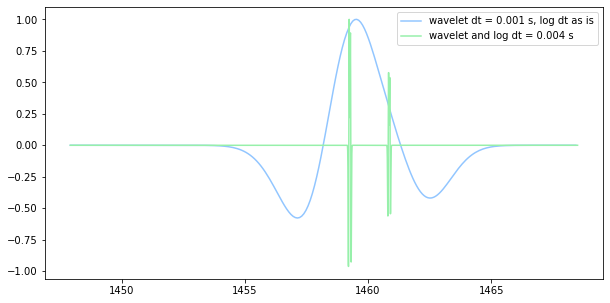

In [152]:
# RESAMPLING FUNCTION
dt = 0.004
maxt = max(time)
t = np.arange(min(time), maxt, dt) 
Z_t = np.interp(x = t, xp = time, fp = ai)
RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1])

#Create synthetic
gain = 5
syn = np.convolve(rc,y,mode='same')
trace= syn / np.max(np.abs(syn))

#Create synthetic
gain = 5
syn2 = np.convolve(RC_t,y2,mode='same')
trace2 = syn2 / np.max(np.abs(syn2))

plt.figure(figsize=(10,5))
plt.plot(time[:-1],trace, label="wavelet dt = 0.001 s, log dt as is")
plt.plot(t[:-1],trace2, label= 'wavelet and log dt = 0.004 s')
plt.legend()

In [155]:
#initial log dt
print(f'initial log dt : {np.round((time[1]-time[0]),3)}')
print(f'resampled log dt : {np.round((t[1]-t[0]),3)}')

initial log dt : 0.087
resampled log dt : 0.004


In [156]:
#log dt as is
time[:-1]-time[1:]

array([-0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08695652,
       -0.08695652, -0.08695652, -0.08695652, -0.08695652, -0.08

The problem is, when you have too many sample points, they get to close (4ms) (even they have a value in the "jump" of two layer boundary) the RC yields a very small value due to the closeness of the data points.

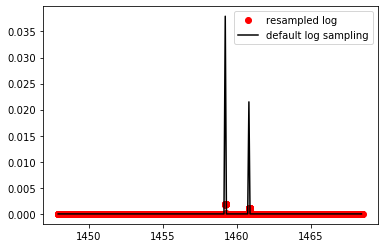

In [163]:

plt.plot(t[:-1],RC_t,'ro',label='resampled log')
plt.plot(time[:-1],rc,color='black',label='default log sampling')
plt.
plt.legend()

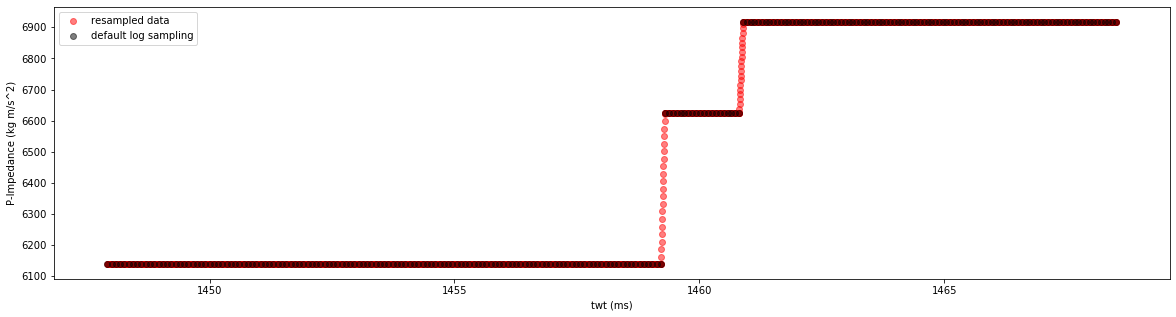

In [173]:
plt.figure(figsize=(20,5))
plt.scatter(t,Z_t,alpha=0.5,c='red',label='resampled data')
plt.scatter(time,ai,alpha=0.5,c='black',label='default log sampling')
plt.xlabel('twt (ms)')
plt.ylabel('P-Impedance (kg m/s^2)')
plt.legend()


you can see from the image above, data value on the jump causing problem